In [23]:
import mnist
import numpy as np
import matplotlib.pyplot as plt
import imageio
import os

In [18]:
train_images = mnist.train_images()[:1000]
test_images = mnist.test_images()[:1000]

In [4]:
train_images.shape

(60000, 28, 28)

In [9]:
train_labels = mnist.train_labels()
test_labels = mnist.test_labels()

In [10]:
train_label_1k = train_labels[:1000]
test_label_1k = test_labels[:1000]

In [12]:
train_count = np.unique(train_label_1k, return_counts=True)
test_count = np.unique(test_label_1k, return_counts=True)

In [13]:
print("Train count", train_count)
print("Test count", test_count)

Train count (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([ 97, 116,  99,  93, 105,  92,  94, 117,  87, 100]))
Test count (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([ 85, 126, 116, 107, 110,  87,  87,  99,  89,  94]))


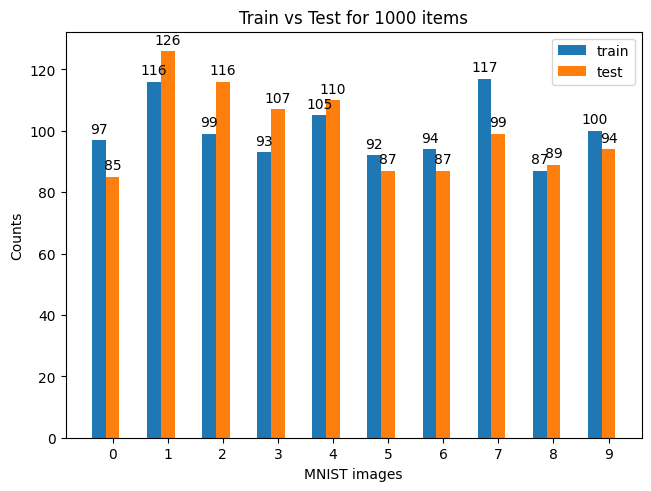

In [17]:
index = train_count[0]
counts = {
    "train": train_count[1], 
    "test": test_count[1]
}

width = 0.25
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in counts.items():
    offset = width * multiplier
    rects = ax.bar(index + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Counts')
ax.set_xlabel('MNIST images')
ax.set_title('Train vs Test for 1000 items')
ax.set_xticks(index + width, index)
ax.legend()
# ax.set_ylim(0, 250)

plt.show()


In [24]:
def _to_padded_strip(images):
    if len(images.shape) <= 3:
        images = np.expand_dims(images, -1)
    c_dim = images.shape[-1]
    x_dim = images.shape[-3]
    y_dim = images.shape[-2]
    padding = 1
    result = np.zeros(
        (x_dim, y_dim * images.shape[0] + padding * (images.shape[0] - 1), c_dim),
        dtype=np.uint8,
    )
    for i in range(images.shape[0]):
        result[:, i * y_dim + i * padding : (i + 1) * y_dim + i * padding, :] = images[
            i
        ]
    if result.shape[-1] == 1:
        result = np.reshape(result, result.shape[:2])
    return result


def save_as_grid(images, save_dir, filename, strip_width=50):
    # Creating a grid of images.
    # images shape: (T, ...)
    results = list([])
    if images.shape[0] < strip_width:
        results.append(_to_padded_strip(images))
    else:
        for i in range(0, images.shape[0], strip_width):
            if i + strip_width < images.shape[0]:
                results.append(_to_padded_strip(images[i : i + strip_width]))
    grid = np.concatenate(results, 0)
    imageio.imwrite(os.path.join(save_dir, filename), grid)
    print("Written grid file {}".format(os.path.join(save_dir, filename)))

In [26]:
save_as_grid(train_images, '.', 'train_images.png')
save_as_grid(test_images, '.', 'test_images.png')


Written grid file ./train_images.png
Written grid file ./test_images.png


In [10]:
normal_train_images = train_images/255.0

In [11]:
np.unique(normal_train_images)

array([0.        , 0.00392157, 0.00784314, 0.01176471, 0.01568627,
       0.01960784, 0.02352941, 0.02745098, 0.03137255, 0.03529412,
       0.03921569, 0.04313725, 0.04705882, 0.05098039, 0.05490196,
       0.05882353, 0.0627451 , 0.06666667, 0.07058824, 0.0745098 ,
       0.07843137, 0.08235294, 0.08627451, 0.09019608, 0.09411765,
       0.09803922, 0.10196078, 0.10588235, 0.10980392, 0.11372549,
       0.11764706, 0.12156863, 0.1254902 , 0.12941176, 0.13333333,
       0.1372549 , 0.14117647, 0.14509804, 0.14901961, 0.15294118,
       0.15686275, 0.16078431, 0.16470588, 0.16862745, 0.17254902,
       0.17647059, 0.18039216, 0.18431373, 0.18823529, 0.19215686,
       0.19607843, 0.2       , 0.20392157, 0.20784314, 0.21176471,
       0.21568627, 0.21960784, 0.22352941, 0.22745098, 0.23137255,
       0.23529412, 0.23921569, 0.24313725, 0.24705882, 0.25098039,
       0.25490196, 0.25882353, 0.2627451 , 0.26666667, 0.27058824,
       0.2745098 , 0.27843137, 0.28235294, 0.28627451, 0.29019

In [15]:
import math
import os
import sys

import numpy as np
from PIL import Image


###########################################################################################
# script to generate moving mnist video dataset (frame by frame) as described in
# [1] arXiv:1502.04681 - Unsupervised Learning of Video Representations Using LSTMs
#     Srivastava et al
# by Tencia Lee
# saves in hdf5, npz, or jpg (individual frames) format
###########################################################################################

# helper functions
def arr_from_img(im, mean=0, std=1):
    '''

    Args:
        im: Image
        shift: Mean to subtract
        std: Standard Deviation to subtract

    Returns:
        Image in np.float32 format, in width height channel format. With values in range 0,1
        Shift means subtract by certain value. Could be used for mean subtraction.
    '''
    width, height = im.size
    arr = im.getdata()
    c = int(np.product(arr.size) / (width * height))

    return (np.asarray(arr, dtype=np.float32).reshape((height, width, c)).transpose(2, 1, 0) / 255. - mean) / std


def get_image_from_array(X, index, mean=0, std=1):
    '''

    Args:
        X: Dataset of shape N x C x W x H
        index: Index of image we want to fetch
        mean: Mean to add
        std: Standard Deviation to add
    Returns:
        Image with dimensions H x W x C or H x W if it's a single channel image
    '''
    ch, w, h = X.shape[1], X.shape[2], X.shape[3]
    ret = (((X[index] + mean) * 255.) * std).reshape(ch, w, h).transpose(2, 1, 0).clip(0, 255).astype(np.uint8)
    if ch == 1:
        ret = ret.reshape(h, w)
    return ret


# loads mnist from web on demand
def load_dataset(training=True):
    if sys.version_info[0] == 2:
        from urllib import urlretrieve
    else:
        from urllib.request import urlretrieve

    def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
        print("Downloading %s" % filename)
        urlretrieve(source + filename, filename)

    import gzip
    def load_mnist_images(filename):
        if not os.path.exists(filename):
            download(filename)
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
        data = data.reshape(-1, 1, 28, 28).transpose(0, 1, 3, 2)
        return data / np.float32(255)

    if training:
        return load_mnist_images('train-images-idx3-ubyte.gz')
    return load_mnist_images('t10k-images-idx3-ubyte.gz')


def generate_moving_mnist(training, shape=(64, 64), num_frames=30, num_images=100, original_size=28, nums_per_image=2):
    '''

    Args:
        training: Boolean, used to decide if downloading/generating train set or test set
        shape: Shape we want for our moving images (new_width and new_height)
        num_frames: Number of frames in a particular movement/animation/gif
        num_images: Number of movement/animations/gif to generate
        original_size: Real size of the images (eg: MNIST is 28x28)
        nums_per_image: Digits per movement/animation/gif.

    Returns:
        Dataset of np.uint8 type with dimensions num_frames * num_images x 1 x new_width x new_height

    '''
    mnist = load_dataset(training)
    width, height = shape

    # Get how many pixels can we move around a single image
    lims = (x_lim, y_lim) = width - original_size, height - original_size

    # Create a dataset of shape of num_frames * num_images x 1 x new_width x new_height
    # Eg : 3000000 x 1 x 64 x 64
    dataset = np.empty((num_frames * num_images, 1, width, height), dtype=np.uint8)

    for img_idx in range(num_images):
        # Randomly generate direction, speed and velocity for both images
        direcs = np.pi * (np.random.rand(nums_per_image) * 2 - 1)
        speeds = np.random.randint(5, size=nums_per_image) + 2
        veloc = np.asarray([(speed * math.cos(direc), speed * math.sin(direc)) for direc, speed in zip(direcs, speeds)])
        # Get a list containing two PIL images randomly sampled from the database
        mnist_images = [Image.fromarray(get_image_from_array(mnist, r, mean=0)).resize((original_size, original_size),
                                                                                       Image.ANTIALIAS) \
                        for r in np.random.randint(0, mnist.shape[0], nums_per_image)]
        # Generate tuples of (x,y) i.e initial positions for nums_per_image (default : 2)
        positions = np.asarray([(np.random.rand() * x_lim, np.random.rand() * y_lim) for _ in range(nums_per_image)])

        # Generate new frames for the entire num_framesgth
        for frame_idx in range(num_frames):

            canvases = [Image.new('L', (width, height)) for _ in range(nums_per_image)]
            canvas = np.zeros((1, width, height), dtype=np.float32)

            # In canv (i.e Image object) place the image at the respective positions
            # Super impose both images on the canvas (i.e empty np array)
            for i, canv in enumerate(canvases):
                canv.paste(mnist_images[i], tuple(positions[i].astype(int)))
                canvas += arr_from_img(canv, mean=0)

            # Get the next position by adding velocity
            next_pos = positions + veloc

            # Iterate over velocity and see if we hit the wall
            # If we do then change the  (change direction)
            for i, pos in enumerate(next_pos):
                for j, coord in enumerate(pos):
                    if coord < -2 or coord > lims[j] + 2:
                        veloc[i] = list(list(veloc[i][:j]) + [-1 * veloc[i][j]] + list(veloc[i][j + 1:]))

            # Make the permanent change to position by adding updated velocity
            positions = positions + veloc

            # Add the canvas to the dataset array
            dataset[img_idx * num_frames + frame_idx] = (canvas * 255).clip(0, 255).astype(np.uint8)

    return dataset


def main(training, dest, filetype='npz', frame_size=64, num_frames=30, num_images=100, original_size=28,
         nums_per_image=2):
    dat = generate_moving_mnist(training, shape=(frame_size, frame_size), num_frames=num_frames, num_images=num_images, \
                                original_size=original_size, nums_per_image=nums_per_image)
    n = num_images * num_frames
    if filetype == 'npz':
        np.savez(dest, dat)
    elif filetype == 'jpg':
        for i in range(dat.shape[0]):
            Image.fromarray(get_image_from_array(dat, i, mean=0)).save(os.path.join(dest, '{}.jpg'.format(i)))



In [16]:
train_images

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [17]:
width, height = 64, 64

In [18]:
lims = (x_lim, y_lim) = width - 28, height - 28

In [19]:
lims

(36, 36)

In [20]:
direcs = np.pi *(np.random.rand(2)*2-1)

In [21]:
direcs

array([-2.42811947, -0.8130318 ])

In [22]:
speeds = np.random.randint(5, size=2) + 2

In [23]:
speeds

array([6, 2])

In [24]:
veloc = np.asarray([(speed * math.cos(direc), speed*math.sin(direc)) for direc, speed in zip(direcs, speeds)])

In [25]:
veloc

array([[-4.53656021, -3.92678259],
       [ 1.37459875, -1.45274852]])

In [28]:
Image

<module 'PIL.Image' from '/home/intuinno/anaconda3/envs/jaxhpm/lib/python3.12/site-packages/PIL/Image.py'>

In [29]:
positions = np.asarray([(np.random.rand() * x_lim, np.random.rand() * y_lim) for _ in range(2)])

In [30]:
positions

array([[ 8.48658356, 20.76532544],
       [15.41485305,  1.82413109]])

In [34]:
a = np.ones((3,3))

In [35]:
b = np.zeros((8,8))

In [36]:
x, y = 1,2

In [37]:
b[x:x+3, y:y+3] = a

In [38]:
b

array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 1., 1., 0., 0., 0.],
       [0., 0., 1., 1., 1., 0., 0., 0.],
       [0., 0., 1., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]])

In [27]:
mnist

<module 'mnist' from '/home/intuinno/anaconda3/envs/jaxhpm/lib/python3.12/site-packages/mnist/__init__.py'>

In [46]:
train_images_small = mnist.train_images()[:10]
test_images_small = mnist.test_images()[:10]

In [51]:
train_labels_small = mnist.train_labels()[:30]
test_labels_small = mnist.test_labels()[:30]

In [52]:
train_count = np.unique(train_labels_small, return_counts=True)
test_count = np.unique(test_labels_small, return_counts=True)

In [53]:

train_count

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([2, 6, 4, 4, 4, 2, 2, 2, 1, 3]))

In [54]:
test_count

(array([0, 1, 2, 3, 4, 5, 6, 7, 9], dtype=uint8),
 array([5, 4, 1, 1, 5, 3, 3, 3, 5]))